In [230]:
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
import geodatasets
import matplotlib.pyplot as plt
import plotly.express as px


In [231]:
crash_df = pd.read_csv('../Resources/Montgomery_Crash_Data.csv', index_col='Crash Date/Time', parse_dates=True)

In [232]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100889 entries, 2021-04-04 12:00:00 to 2021-08-22 16:41:00
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Report Number      100889 non-null  object 
 1   Weather            100889 non-null  object 
 2   Surface Condition  88836 non-null   object 
 3   Injury Severity    100889 non-null  object 
 4   Vehicle ID         100889 non-null  object 
 5   Vehicle Year       100889 non-null  int64  
 6   Vehicle Make       100883 non-null  object 
 7   Vehicle Model      100864 non-null  object 
 8   Latitude           100889 non-null  float64
 9   Longitude          100889 non-null  float64
 10  geometry           100889 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 9.2+ MB


In [233]:
crash_df.head()

Report Number Weather Surface Condition  \
Crash Date/Time                                               
2021-04-04 12:00:00   MCP26370040   CLEAR               DRY   
2023-12-04 21:37:00   MCP3221002N   CLEAR               DRY   
2024-07-17 21:27:00   MCP9399002C  CLOUDY               WET   
2016-06-21 09:49:00   MCP28240026    RAIN               WET   
2016-12-05 06:55:00   MCP2497000L    RAIN               WET   

                            Injury Severity  \
Crash Date/Time                               
2021-04-04 12:00:00      NO APPARENT INJURY   
2023-12-04 21:37:00  SUSPECTED MINOR INJURY   
2024-07-17 21:27:00  SUSPECTED MINOR INJURY   
2016-06-21 09:49:00      NO APPARENT INJURY   
2016-12-05 06:55:00  SUSPECTED MINOR INJURY   

                                               Vehicle ID  Vehicle Year  \
Crash Date/Time                                                           
2021-04-04 12:00:00  88FCD6CE-A85A-4CBD-9BEC-3B6E6DCF16BB          2021   
2023-12-04 21:37:00  6E02796A-26BA-45CD-88B1-13EEDF7EC29C          2015   
2024-07-17 21:27:00  70D8BF87-2BB7-4092-9267-0AD9E7E42978          2004   
2016-06-21 09:49:00  334BEA8D-C367-4DFB-8A70-93750F1BCFBC          2008   
2016-12-05 06:55:00  B8B60239-5172-4024-846A-0EAFD3A7E0B2          2004   

                    Vehicle Make   Vehicle Model   Latitude  Longitude  \
Crash Date/Time                                                          
2021-04-04 12:00:00         MITS          DELOCA  39.057201 -77.293102   
2023-12-04 21:37:00       TOYOTA            RAV4  39.058683 -77.290703   
2024-07-17 21:27:00         JEEP  GRAND CHEROKEE  39.063110 -77.295795   
2016-06-21 09:49:00         HOND              4S  39.063192 -77.296605   
2016-12-05 06:55:00        VOLVO             S60  39.063220 -77.295740   

                                                   geometry  
Crash Date/Time                                              
2021-04-04 12:00:00        POINT (-77.29310223 39.05720146)  
2023-12-04 21:37:00        POINT (-77.29070333 39.05868333)  
2024-07-17 21:27:00  POINT (-77.29579535000001 39.06310977)  
2016-06-21 09:49:00          POINT (-77.296605 39.06319167)  
2016-12-05 06:55:00              POINT (-77.29574 39.06322)

In [234]:
montgomery_gdf = gpd.GeoDataFrame(crash_df, geometry=gpd.points_from_xy(crash_df.Longitude, crash_df.Latitude), crs='EPSG:4326').sort_index()


In [235]:
#time of day accident tend to happen the most?

In [236]:
county_gdf = gpd.read_file('../Resources/Montgomery_County.json')
county_gdf

FID      County     State Country   FIPS                  Combined  \
0    0  Montgomery  Maryland      US  24031  Montgomery, Maryland, US   

   12_31_22  Pct_Total                                           geometry  
0    131345    21.9854  POLYGON ((-77.00249 38.96595, -77.00241 38.966...

<Axes: >

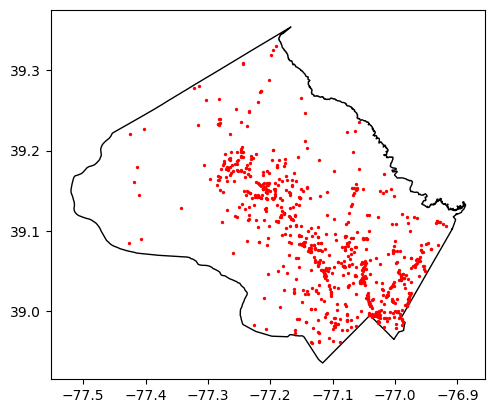

In [237]:
base = county_gdf.plot(color='white', edgecolor='black')
montgomery_gdf.loc['2021-06'].plot(ax=base, marker='o', color='red', markersize=2)

In [238]:
# world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
# fig, ax = plt.subplots(figsize=(24, 18))
# world.plot(ax=ax, alpha=0.4, color="grey")
# county_gdf.plot(column="County", ax=ax, legend=True)
# plt.title("Volcanoes")


In [239]:
m = folium.Map(location=[39.1364, -77.1715], tiles="Cartodb dark_matter", zoom_start=11) 

for _, r in county_gdf.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "none"})
    folium.Popup(r["County"]).add_to(geo_j)
    geo_j.add_to(m)


heat_data = [[point.xy[1][0], point.xy[0][0]] for point in montgomery_gdf.loc['2020'].geometry]
plugins.HeatMap(heat_data, min_opacity=.2, radius=20,zoom_start=2).add_to(m)


for point in heat_data:
    folium.CircleMarker(point, radius=.2, fill_color="black", color="blue").add_to(m)

# fg = folium.FeatureGroup(name="Icon collection", show=False).add_to(m)    
folium.LayerControl().add_to(m)

m

In [240]:
fig = px.density_mapbox(montgomery_gdf.loc['2020'], lat='Latitude', lon='Longitude', z='Vehicle Year', radius=15,
                        center = {'lat':39.1364,'lon':-77.1715}, zoom= 11, mapbox_style='carto-darkmatter', height=900, opacity=.5 )
fig.show()

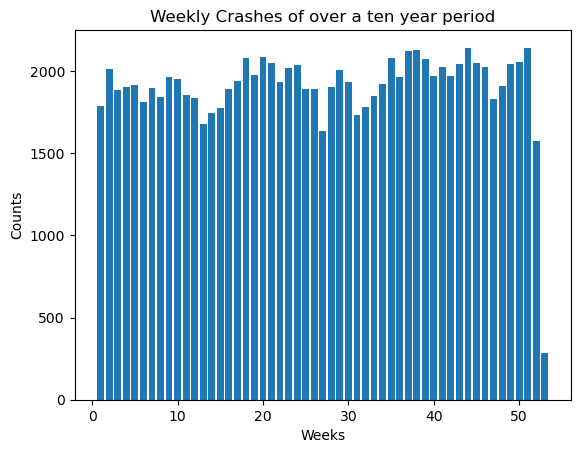

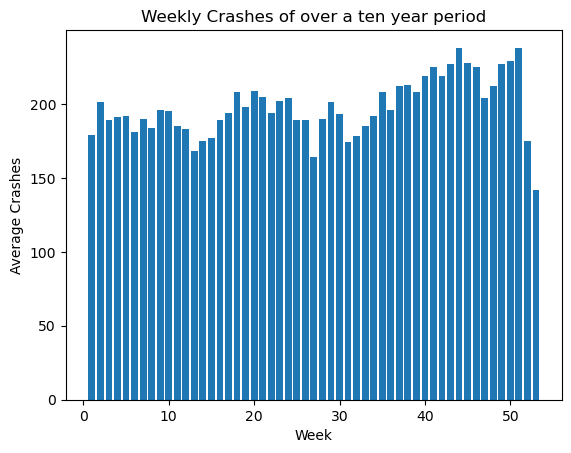

year  week  Report Number
0    2015     1            105
1    2015     2            220
2    2015     3            193
3    2015     4            199
4    2015     5            199
..    ...   ...            ...
504  2024    35            214
505  2024    36            171
506  2024    37            212
507  2024    38            147
508  2024    39             48

[509 rows x 3 columns]

In [246]:
weeks = crash_df.index.isocalendar().week.sort_values().unique()

plt.bar(weeks, crash_df.index.isocalendar().week.value_counts().sort_index())
plt.title('Weekly Crashes of over a ten year period')
plt.xlabel('Weeks')
plt.ylabel('Counts')
plt.show()


weekly_crash_count = crash_df.groupby([crash_df.index.isocalendar().year, crash_df.index.isocalendar().week])['Report Number'].count().reset_index()
plt.bar(weeks, weekly_crash_count.groupby('week')['Report Number'].mean().round())
plt.title('Weekly Crashes of over a ten year period')
plt.xlabel('Week')
plt.ylabel('Average Crashes')
plt.show()

weekly_crash_count


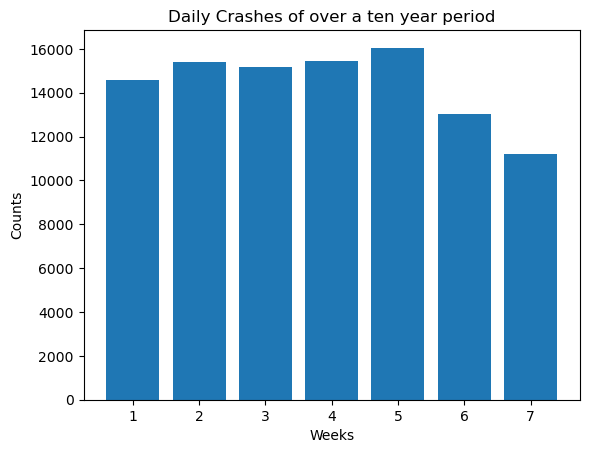

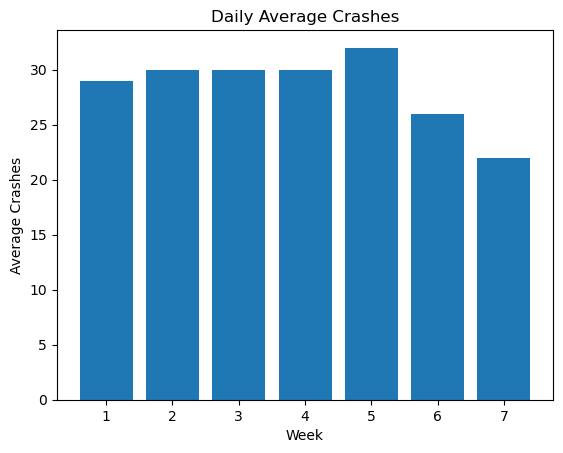

In [258]:
days = crash_df.index.isocalendar().day.sort_values().unique()

plt.bar(days, crash_df.index.isocalendar().day.value_counts().sort_index())
plt.title('Daily Crashes of over a ten year period')
plt.xlabel('Weeks')
plt.ylabel('Counts')
plt.show()


daily_crash_count = crash_df.groupby([crash_df.index.isocalendar().year, crash_df.index.isocalendar().week, crash_df.index.isocalendar().day])['Report Number'].count().reset_index()

plt.bar(days, daily_crash_count.groupby('day')['Report Number'].mean().round())
plt.title('Daily Average Crashes')
plt.xlabel('Week')
plt.ylabel('Average Crashes')
plt.show()

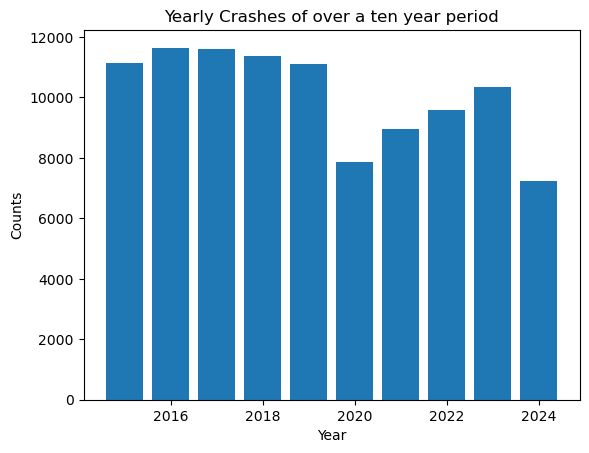

In [257]:
years = crash_df.index.isocalendar().year.sort_values().unique()
plt.bar(years, montgomery_gdf.index.isocalendar().year.value_counts().sort_index())
plt.title('Yearly Crashes of over a ten year period')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.show()